In [20]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate
import mir_eval

from scipy import signal, ndimage
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
import IPython.display as ipd

from scipy.signal import argrelmax
import textwrap

In [3]:
def compute_tempogram_fourier(x, Fs, N, H, Theta=np.arange(30, 601, 1)):
    """Compute Fourier-based tempogram [FMP, Section 6.2.2]
    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM) (Default value = np.arange(30, 601, 1))

    Returns:
        X (np.ndarray): Tempogram
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_BPM (np.ndarray): Tempo axis (BPM)
    """
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    # x_pad = np.pad(x, (L_left, L_right), 'constant')  # doesn't work with jit
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    K = len(Theta)
    X = np.zeros((K, M), dtype=np.complex_)

    for k in range(K):
        omega = (Theta[k] / 60) / Fs
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        x_exp = x_pad * exponential
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            X[k, n] = np.sum(win * x_exp[t_0:t_1])
        T_coef = np.arange(M) * H / Fs
        F_coef_BPM = Theta
    return X, T_coef, F_coef_BPM

In [4]:
def compute_local_average(x, M):
    """Compute local average of signal
    Args:
        x (np.ndarray): Signal
        M (int): Determines size (2M+1) in samples of centric window  used for local average

    Returns:
        local_average (np.ndarray): Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

In [5]:
def compute_novelty_spectrum(x, Fs=1, N=1024, H=256, gamma=100.0, M=10, norm=True):
    """Compute spectral-based novelty function
    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 1024)
        H (int): Hop size (Default value = 256)
        gamma (float): Parameter for logarithmic compression (Default value = 100.0)
        M (int): Size (frames) of local average (Default value = 10)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_spectrum (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """

    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    return novelty_spectrum, Fs_feature

In [6]:
def resample_signal(x_in, Fs_in, Fs_out=100, norm=True, time_max_sec=None, sigma=None):
    """Resample and smooth signal
    Args:
        x_in (np.ndarray): Input signal
        Fs_in (scalar): Sampling rate of input signal
        Fs_out (scalar): Sampling rate of output signal (Default value = 100)
        norm (bool): Apply max norm (if norm==True) (Default value = True)
        time_max_sec (float): Duration of output signal (given in seconds) (Default value = None)
        sigma (float): Standard deviation for smoothing Gaussian kernel (Default value = None)
    Returns:
        x_out (np.ndarray): Output signal
        Fs_out (scalar): Feature rate of output signal
    """
    if sigma is not None:
        x_in = ndimage.gaussian_filter(x_in, sigma=sigma)
    T_coef_in = np.arange(x_in.shape[0]) / Fs_in
    time_in_max_sec = T_coef_in[-1]
    if time_max_sec is None:
        time_max_sec = time_in_max_sec
    N_out = int(np.ceil(time_max_sec*Fs_out))
    T_coef_out = np.arange(N_out) / Fs_out
    if T_coef_out[-1] > time_in_max_sec:
        x_in = np.append(x_in, [0])
        T_coef_in = np.append(T_coef_in, [T_coef_out[-1]])
    x_out = interp1d(T_coef_in, x_in, kind='linear')(T_coef_out)
    if norm:
        x_max = max(x_out)
        if x_max > 0:
            x_out = x_out / max(x_out)
    return x_out, Fs_out

In [7]:
def plot_signal(x, Fs=1, T_coef=None, ax=None, figsize=(6, 2), xlabel='Time (seconds)', ylabel='', title='', dpi=72,
                ylim=True, **kwargs):
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1, 1, 1)
    if T_coef is None:
        T_coef = np.arange(x.shape[0]) / Fs

    if 'color' not in kwargs:
        kwargs['color'] = 'gray'

    line = ax.plot(T_coef, x, **kwargs)

    ax.set_xlim([T_coef[0], T_coef[-1]])
    if ylim is True:
        ylim_x = x[np.isfinite(x)]
        x_min, x_max = ylim_x.min(), ylim_x.max()
        if x_max == x_min:
            x_max = x_max + 1
        ax.set_ylim([min(1.1 * x_min, 0.9 * x_min), max(1.1 * x_max, 0.9 * x_max)])
    elif ylim not in [True, False, None]:
        ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if fig is not None:
        plt.tight_layout()

    return fig, ax, line

In [8]:
def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

In [9]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [10]:
def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    """Compute local autocorrelation [FMP, Section 6.2.3]

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb

    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        norm_sum (bool): Normalizes by the number of summands in local autocorrelation (Default value = True)

    Returns:
        A (np.ndarray): Time-lag representation
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_lag (np.ndarray): Lag axis
    """
    # L = len(x)
    L_left = round(N / 2)
    L_right = L_left
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    A = np.zeros((N, M))
    win = np.ones(N)
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        x_local = win * x_pad[t_0:t_1]
        r_xx = np.correlate(x_local, x_local, mode='full')
        r_xx = r_xx[N-1:]
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        A[:, n] = r_xx
    Fs_A = Fs / H
    T_coef = np.arange(A.shape[1]) / Fs_A
    F_coef_lag = np.arange(N) / Fs
    return A, T_coef, F_coef_lag

In [11]:
def compute_tempogram_autocorr(x, Fs, N, H, norm_sum=False, Theta=np.arange(30, 601)):
    """Compute autocorrelation-based tempogram

    Notebook: C6/C6S2_TempogramAutocorrelation.ipynb

    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        norm_sum (bool): Normalizes by the number of summands in local autocorrelation (Default value = False)
        Theta (np.ndarray): Set of tempi (given in BPM) (Default value = np.arange(30, 601))

    Returns:
        tempogram (np.ndarray): Tempogram tempogram
        T_coef (np.ndarray): Time axis T_coef (seconds)
        F_coef_BPM (np.ndarray): Tempo axis F_coef_BPM (BPM)
        A_cut (np.ndarray): Time-lag representation A_cut (cut according to Theta)
        F_coef_lag_cut (np.ndarray): Lag axis F_coef_lag_cut
    """
    tempo_min = Theta[0]
    tempo_max = Theta[-1]
    lag_min = int(np.ceil(Fs * 60 / tempo_max))
    lag_max = int(np.ceil(Fs * 60 / tempo_min))
    A, T_coef, F_coef_lag = compute_autocorrelation_local(x, Fs, N, H, norm_sum=norm_sum)
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    F_coef_BPM = Theta
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(F_coef_BPM)
    return tempogram, T_coef, F_coef_BPM, A_cut, F_coef_lag_cut

In [12]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [13]:
def get_estimate_tempo(frequency_scale, tempogram, scale):
    tempo_vector = np.sum(tempogram, axis=1)
    peak_index = argrelmax(tempo_vector)
    # 找相對最大值 => 峰值
    # x = np.array([2, 1, 2, 3, 2, 0, 1, 0])
    # argrelmax(x)
    # output:(array([3, 6]),)
    # print(peak_index)
    zip_find_peak = zip(tempo_vector[peak_index], frequency_scale[peak_index])
    # print(list(zip_peak))
    peaks = sorted(zip_find_peak, key=lambda x: x[0], reverse=True) #大到小排序
    # print(peaks)
    tempos = peaks[:2]
    # print(tempos)
    if tempos[0][1] > tempos[1][1]: #取出的前兩大峰值之 frequency 以小到大排序
        tempos = tempos[::-1]
    # print(tempos)
    # 顯著性(saliency) 𝑆1 = 𝐹(𝑇1, 𝑛)/(𝐹(𝑇1, 𝑛) + 𝐹(𝑇2, 𝑛)) for tempo value 𝑡 at a specific time at 𝑛
    s1 = tempos[0][0] / (tempos[0][0] + tempos[1][0])
    return [scale * tempos[0][1], scale * tempos[1][1]], s1

In [14]:
# 𝑃 score = 𝑆1 * 𝑇_𝑡1 + (1 − 𝑆1) * 𝑇_𝑡2
def get_p_score(big_t, s1):
    return (s1 * big_t[0]) + ((1 - s1) * big_t[1])

In [15]:
def get_alotc_score(likely_tempos, ground_truth):
    alotc_score = 0
    if abs((ground_truth - likely_tempos[0])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[0])/ground_truth) == 0.08:
        alotc_score = 1
    elif abs((ground_truth - likely_tempos[1])/ground_truth) < 0.08 or abs((ground_truth - likely_tempos[1])/ground_truth) == 0.08:
        alotc_score = 1
    else:
        alotc_score = 0
    return alotc_score

In [16]:
genres_list = ["ChaCha", "Jive", "Quickstep", "Rumba", "Samba", "Tango", "Viennese waltz", "Waltz"]
tempogram_list = ["fourier", "autocorrelation"]

In [17]:
album_list = ["Abba", "Alan_Parsons_Project", "Alirio Diaz", "aphex_twin", "Asian_Dub_Foundation", "Autechre",
              "Aviador_Dro", "Bach", "Bach - Walcha", "Bebel_Gilberto", "Bela_Bartok", "Bernstein_conducts_Stravinsky",
              "Billie Holiday CD1", "Bjork", "Cabaret_Voltaire", "Carlinhos_Brown", "charles_mingus", "Classic",
              "Elton Medeiros, Nelson Sargento & Galo Preto", "Fado", "Femi_Kuti", "Genesis", "greek", "GUITARE+",
              "john_coltrane", "John Frusciante", "Jose' Merce'", "Kocani Orkester", "Manu_Chao", "more greek",
              "Nina Pastori", "Olivier Chassain", "Papakonstantinou", "Paulinho da Viola & Elton Medeiros", "Santana",
              "Songs", "Teresa Cristina", "Tomatito", "Vangelis", "Xatzidakis"]

In [90]:
def get_beat_tracking(visualization):
    # path = "./HW2 Datasets/Ballroom/"
    wav_path = "./HW2 Datasets/Ballroom/BallroomData/"
    ground_truth_path = "./HW2 Datasets/Ballroom/BallroomAnnotations-master/"
    f_score_dict = {}
    for genre in genres_list:
        f_score_dict[genre] = {}
        for root, dirs, files in os.walk(os.path.join(wav_path, genre)):
            files = sorted(files, key=sort_key_num)
            # print(files)
            song_no = 0
            for name in files:
                if name.endswith((".wav")):
                    f_score_dict[genre][song_no] = {}
                    # tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
                    audio_file_path = wav_path + genre + "/" + name
                    # print("audio_file_path: ", audio_file_path)
                    bpm_name = name.replace(".wav", ".beats")

                    sr = 22050
                    audio, sr = librosa.load(audio_file_path, sr = sr)
                    
                    tempo, beat_times = librosa.beat.beat_track(y = audio, sr = sr)#  start_bpm = 60, units = 'time'
                    estimate_beats = librosa.frames_to_time(beat_times, sr = sr)
                    # print(tempo)
                    # print(beat_times)
                    
                    if visualization == 1:
                        plt.figure(figsize=(14, 5))
                        librosa.display.waveshow(audio, alpha=0.6)
                        plt.vlines(beat_times, -1, 1, color='r')
                        plt.ylim(-1, 1)
                        plt.show()
                        
                        beat_times_diff = np.diff(beat_times)
                        plt.figure(figsize=(14, 5))
                        plt.hist(beat_times_diff, bins=50, range=(0,4))
                        plt.xlabel('Beat Length (seconds)')
                        plt.ylabel('Count')
                        plt.show()

                    ground_truth_beats, _ = mir_eval.io.load_labeled_events(os.path.join(ground_truth_path, bpm_name))
                    #print(ground_truth_beats)
                    ground_truth_beats = mir_eval.beat.trim_beats(ground_truth_beats)
                    #located within a tolerance of ±70 ms around the ground truth annotation, 70ms = 0.007sec
                    # f_score = mir_eval.beat.f_measure(ground_truth_beats, beat_times, f_measure_threshold = 0.07)
                    f_score = mir_eval.beat.f_measure(ground_truth_beats, estimate_beats, f_measure_threshold = 0.07)
                    
                    # print('f_score:', f_score)
                    f_score_dict[genre][song_no]["f_score"] = f_score
                    song_no += 1
    return f_score_dict

In [91]:
f_score_dict = get_beat_tracking(0)

In [92]:
f_score_dict

{'ChaCha': {0: {'f_score': 0.9043478260869565},
  1: {'f_score': 0.890909090909091},
  2: {'f_score': 0.8928571428571428},
  3: {'f_score': 0.8928571428571428},
  4: {'f_score': 0.8571428571428571},
  5: {'f_score': 0.9026548672566371},
  6: {'f_score': 0.8928571428571429},
  7: {'f_score': 0.911764705882353},
  8: {'f_score': 0.9009009009009009},
  9: {'f_score': 0.8712871287128713},
  10: {'f_score': 0.8965517241379309},
  11: {'f_score': 0.8571428571428572},
  12: {'f_score': 0.9043478260869565},
  13: {'f_score': 0.8928571428571428},
  14: {'f_score': 0.6428571428571429},
  15: {'f_score': 0.8928571428571428},
  16: {'f_score': 0.8928571428571428},
  17: {'f_score': 0.8869565217391304},
  18: {'f_score': 0.12068965517241378},
  19: {'f_score': 0.8928571428571429},
  20: {'f_score': 0.8928571428571428},
  21: {'f_score': 0.8623853211009175},
  22: {'f_score': 0.8113207547169811},
  23: {'f_score': 0.8965517241379309},
  24: {'f_score': 0.8990825688073394},
  25: {'f_score': 0.896551

In [93]:
columns = ['genre', 'song_no', 'f_score']
score_dict_df = pd.DataFrame.from_dict({(i, j): f_score_dict[i][j]
                            for i in f_score_dict.keys() 
                            for j in f_score_dict[i].keys()
                            }, orient='columns').T

score_dict_df.reset_index(inplace=True)
score_dict_df.columns = ['genre', 'song_no', 'f_score']

In [94]:
score_dict_df

,genre,song_no,f_score
0,ChaCha,0,0.904348
1,ChaCha,1,0.890909
2,ChaCha,2,0.892857
3,ChaCha,3,0.892857
4,ChaCha,4,0.857143
...,...,...,...
693,Waltz,105,0.448276
694,Waltz,106,0.794872
695,Waltz,107,0.553571
696,Waltz,108,0.876712


In [95]:
group_by_genre = score_dict_df.drop(columns=['song_no']).groupby("genre")
result_group_by_genre = group_by_genre.mean()
result_group_by_genre

,f_score
genre,
ChaCha,0.830125
Jive,0.625956
Quickstep,0.583471
Rumba,0.725350
Samba,0.517041
Tango,0.740452
Viennese waltz,0.677363
Waltz,0.583254


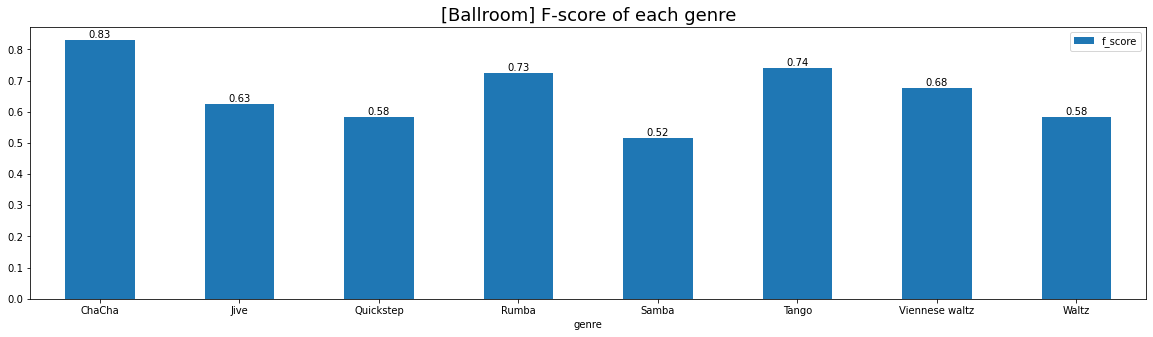

In [96]:
ax = result_group_by_genre.plot(kind='bar', figsize=(20, 5), rot=0)
ax.set_title("[Ballroom] F-score of each genre", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

/tmp/ipykernel_1773667/316004041.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_ballroom = score_dict_df.drop(columns=['song_no']).mean()


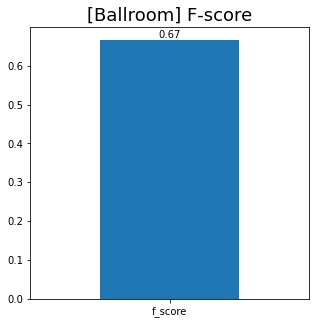

In [98]:
result_ballroom = score_dict_df.drop(columns=['song_no']).mean()

ax = result_ballroom.plot(kind='bar', figsize=(5, 5), rot=0)
ax.set_title("[Ballroom] F-score", fontsize=18)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

## =========================================================